# Sequence Learning - Word Training - English - Testing Session - Stats
In this session, we will look into the working status of our HMRNN-based AE and do stat on:   
- How many times for each word the predicted sub-segments are more than the real segments;   
-  ...  

In [1]:
import torch
import torchaudio
from torch import nn
import torch.nn.functional as F
from torch.nn.utils.rnn import pad_sequence, pack_sequence
from torch import optim
from torch.utils.data import Dataset, DataLoader, random_split
import matplotlib.pyplot as plt
import numpy as np
# import csv
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.metrics import homogeneity_completeness_v_measure
import pickle
from paths import *
from my_utils import *
from padding import generate_mask_from_lengths_mat, mask_it, masked_loss
# import pytz
from datetime import datetime
# import random
# import gc
import seaborn as sns

In [2]:
# from model import PhonLearn_Net
from model import PhonLearn_Net
# DirectPassModel, TwoRNNModel, TwoRNNAttn

### Dirs

In [3]:
model_save_dir = model_eng_save_dir
# random_data:phone_seg_random_path
# anno_data: phone_seg_anno_path

# random_log_path = phone_seg_random_log_path + "log.csv"
random_log_path = word_seg_anno_log_path
random_path = word_seg_anno_path
anno_log_path = phone_seg_anno_path

### Constants

In [4]:
# 规范用语；规定两种方式：全加载；按rec加载（舍弃了按chunk加载，处理起来更简单）
# RandomPhoneDataset; AnnoPhoneDataset; AnnoSeqDataset

In [5]:
class AnnoWordWholeDataset(Dataset):
    """
    A PyTorch dataset that loads cutted wave files from disk and returns input-output pairs for
    training autoencoder. 
    
    Version 3: wav -> mel
    """
    
    def __init__(self, load_dir, load_control_path, transform=None):
        """
        Initializes the class by reading a CSV file and merging the "rec" and "idx" columns.

        The function reads the CSV file from the provided control path, extracts the "rec" and "idx" columns,
        and concatenates the values from these columns using an underscore. It then appends the ".wav" extension
        to each of the merged strings and converts the merged pandas Series to a list, which is assigned to
        the 'dataset' attribute of the class.

        Args:
        load_dir (str): The directory containing the files to load.
        load_control_path (str): The path to the CSV file containing the "rec" and "idx" columns.

        Attributes:
        dataset (list): A list of merged strings from the "rec" and "idx" columns, with the ".wav" extension.
        """
        control_file = pd.read_csv(load_control_path)
        control_file = control_file[control_file['n_frames'] > 400]
        control_file = control_file[control_file['duration'] <= 2.0]
        
        # Extract the "rec" and "idx" columns
        rec_col = control_file['rec'].astype(str)
        idx_col = control_file['idx'].astype(str).str.zfill(8)

        # Extract the "token" and "produced_segments" columns
        token_col = control_file['token'].astype(str)
        produced_segments_col = control_file['produced_segments'].astype(str)
        num_segs_col = produced_segments_col.apply(lambda x: len(x.split()))
        
        # Merge the two columns by concatenating the strings with '_' and append extension name
        merged_col = rec_col + '_' + idx_col + ".wav"
        
        self.dataset = merged_col.tolist()
        self.infoset = num_segs_col.tolist()
        self.load_dir = load_dir
        self.transform = transform
        self.info_rec_set = rec_col.tolist()
        self.info_idx_set = idx_col.tolist()
        self.info_token_set = token_col.tolist()
        
    
    def __len__(self):
        """
        Returns the length of the dataset.
        
        Returns:
            int: The number of input-output pairs in the dataset.
        """
        return len(self.dataset)
    
    def __getitem__(self, idx):
        """
        Returns a tuple (input_data, output_data) for the given index.

        The function first checks if the provided index is a tensor, and if so, converts it to a list.
        It then constructs the file path for the .wav file using the dataset attribute and the provided index.
        The .wav file is loaded using torchaudio, and its data is normalized. If a transform is provided,
        the data is transformed using the specified transform. Finally, the input_data and output_data are
        set to the same data (creating a tuple), and the tuple is returned.

        Args:
        idx (int or torch.Tensor): The index of the desired data.

        Returns:
        tuple: A tuple containing input_data and output_data, both of which are the audio data
               from the .wav file at the specified index.

        Note: 
        This function assumes that the class has the following attributes:
        - self.load_dir (str): The directory containing the .wav files.
        - self.dataset (list): A list of .wav file names.
        - self.transform (callable, optional): An optional transform to apply to the audio data.
        """
        if torch.is_tensor(idx):
            idx = idx.tolist()
        wav_name = os.path.join(self.load_dir,
                                self.dataset[idx])
        
        data, sample_rate = torchaudio.load(wav_name, normalize=True)
        if self.transform:
            data = self.transform(data, sr=sample_rate)
        
        info = self.infoset[idx]
        # extra info for completing a csv
        info_rec = self.info_rec_set[idx]
        info_idx = self.info_idx_set[idx]
        info_token = self.info_token_set[idx]
        
        
        # # Prepare for possible in-out discrepencies in the future
        # input_data = data
        # output_data = data
        
        return data, info, info_rec, info_idx, info_token

def collate_fn(data):
    xx, yy, aa, bb, cc = zip(*data)
    # only working for one data at the moment
    batch_first = True
    x_lens = [len(x) for x in xx]
    xx_pad = pad_sequence(xx, batch_first=batch_first, padding_value=0)
    return xx_pad, x_lens, yy, aa, bb, cc


class MyTransform(nn.Module): 
    def __init__(self, sample_rate, n_fft): 
        super().__init__()
        # self.transform = torchaudio.transforms.MelSpectrogram(sample_rate, n_fft=n_fft, n_mels=64)
        # self.to_db = torchaudio.transforms.AmplitudeToDB()
        # self.transform = torchaudio.transforms.MFCC(n_mfcc=13)
    
    def forward(self, waveform, sr=16000): 
        # extract mfcc
        feature = torchaudio.compliance.kaldi.mfcc(waveform, sample_frequency=sr)

        # add deltas
        d1 = torchaudio.functional.compute_deltas(feature)
        d2 = torchaudio.functional.compute_deltas(d1)
        feature = torch.cat([feature, d1, d2], dim=-1)

        # Apply normalization (CMVN)
        eps = 1e-9
        mean = feature.mean(0, keepdim=True)
        std = feature.std(0, keepdim=True, unbiased=False)
        # print(feature.shape)
        # print(mean, std)
        feature = (feature - mean) / (std + eps)

        # mel_spec = self.transform(waveform)
        # # mel_spec = self.to_db(mel_spec)
        # mel_spec = mel_spec.squeeze()
        # mel_spec = mel_spec.permute(1, 0) # (F, L) -> (L, F)
        return feature

In [6]:
# # NOTE: THIS IS HOW WE CAN CREATE THE DATASET AND DATALOADER
# sample_rate = 16000
# n_fft = 400

# transform = MyTransform(sample_rate, n_fft)

# ds = PhoneDataset(phone_seg_random_path, phone_seg_random_log_path + "s0101a.csv", transform=transform)

# test_dl = DataLoader(ds, batch_size=2, shuffle=True, collate_fn=collate_fn)

# indata, in_lens = next(iter(test_dl))

# print(indata.shape, in_lens)

In [7]:
EPOCHS = 10
BATCH_SIZE = 128

# SEGMENTS_IN_CHUNK = 100  # set_size

# INPUT_DIM = 128
# OUTPUT_DIM = 128

INPUT_DIM = 39
OUTPUT_DIM = 13

INTER_DIM_0 = 16
INTER_DIM_1 = 8
INTER_DIM_2 = 3
INTER_DIM_3 = 3

SIZE_LIST = [INTER_DIM_1, INTER_DIM_2]

DROPOUT = 0.5

REC_SAMPLE_RATE = 16000
N_FFT = 400

LOADER_WORKER = 0

In [8]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# device = torch.device('cpu')
recon_loss = nn.MSELoss(reduction='none')
# model = TwoRNNAttn(1.0, SIZE_LIST, in_size=INPUT_DIM, 
#                       in2_size=INTER_DIM_0, hid_size=INTER_DIM_3, out_size=OUTPUT_DIM)
model = PhonLearn_Net(1.0, SIZE_LIST, in_size=INPUT_DIM, 
                      in2_size=INTER_DIM_0, hid_size=INTER_DIM_3, out_size=OUTPUT_DIM)
model.to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [9]:
model

PhonLearn_Net(
  (encoder): Encoder(
    (lin_1): LinearPack(
      (linear): Linear(in_features=39, out_features=16, bias=True)
      (relu): Tanh()
      (dropout): Dropout(p=0.5, inplace=False)
    )
    (rnn): HM_LSTM(
      (cell_1): HM_LSTMCell()
      (cell_2): HM_LSTMCell()
    )
  )
  (decoder): Decoder(
    (lin_1): LinearPack(
      (linear): Linear(in_features=13, out_features=3, bias=True)
      (relu): Tanh()
      (dropout): Dropout(p=0.5, inplace=False)
    )
    (rnn): LSTM(3, 16, batch_first=True)
    (attention): ScaledDotProductAttention(
      (w_q): Linear(in_features=16, out_features=16, bias=True)
      (w_k): Linear(in_features=3, out_features=16, bias=True)
      (w_v): Linear(in_features=3, out_features=16, bias=True)
    )
    (lin_2): LinearPack(
      (linear): Linear(in_features=16, out_features=13, bias=True)
      (relu): Tanh()
      (dropout): Dropout(p=0.5, inplace=False)
    )
  )
)

In [10]:
# READ = False
READ = True

In [11]:
if READ: 
    # valid_losses.read()
    # train_losses.read()

    # model_name = last_model_name
    model_name = "PT_0623152604_35_full.pt"
    model_path = os.path.join(model_save_dir, model_name)
    state = torch.load(model_path)
    model = PhonLearn_Net(1.0, SIZE_LIST, in_size=INPUT_DIM, 
                      in2_size=INTER_DIM_0, hid_size=INTER_DIM_3, out_size=OUTPUT_DIM)
    model.load_state_dict(state)
    # device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)

In [12]:
mytrans = MyTransform(sample_rate=REC_SAMPLE_RATE, n_fft=N_FFT)
ds = AnnoWordWholeDataset(random_path, os.path.join(random_log_path, "log.csv"), transform=mytrans)
# small_len = int(0.1 * len(ds))
# other_len = len(ds) - small_len

# # Randomly split the dataset into train and validation sets
# ds, other_ds = random_split(ds, [small_len, other_len])

train_len = int(0.8 * len(ds))
valid_len = len(ds) - train_len

# Randomly split the dataset into train and validation sets
train_ds, valid_ds = random_split(ds, [train_len, valid_len])

# train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=LOADER_WORKER, collate_fn=collate_fn)
# train_num = len(train_loader.dataset)

valid_loader = DataLoader(valid_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=LOADER_WORKER, collate_fn=collate_fn)
valid_num = len(valid_loader.dataset)

In [13]:
len(valid_loader)

444

In [22]:
def infer(model_num=""): 
    columns = ['rec', 'idx', 'token']
    compara_df = pd.DataFrame(columns=columns)

    model.eval()
    for idx, (x, x_lens, info, info_rec, info_idx, info_token) in enumerate(valid_loader):
        x_mask = generate_mask_from_lengths_mat(x_lens, device=device)
        
        x = x.to(device)

        hid_r, z_1, z_2 = model.encode(x, x_mask)

        # at present we only look at z_1, which is noting timesteps of report
        # if the first z_1 is not 1, default (0) will be reported repeatedly until an occasion when z_1 == 1
        # At present, let's just ignore the all-zero part before report 
        num_subsegments = torch.sum(z_1, dim=(1, 2))    # sum over L, H of (B, L, H)

        # convert all to cpu
        num_subsegments = num_subsegments.cpu()
        num_mfcc_frames = x.size(1)
        # Create a dictionary with the new data
        new_data = {'rec': info_rec,
                    'idx': info_idx,
                    'token': info_token,
                    'num_produced_segments': info,
                    'num_subsegments': num_subsegments, 
                    'num_mfcc_frames': num_mfcc_frames}
        new_data = pd.DataFrame.from_dict(new_data)
        
        # Append the new data to the DataFrame
        compara_df = pd.concat((compara_df, new_data), ignore_index=True)
        if idx % 10 == 0:
            print(f"Inference at step {idx}")
    compara_df.to_csv(os.path.join(word_seg_anno_log_path, 'compara_{}.csv'.format(model_num)), index=False)
        

In [23]:
if __name__ == "__main__": 
    infer()

Inference at step 0
Inference at step 10
Inference at step 20
Inference at step 30
Inference at step 40
Inference at step 50
Inference at step 60
Inference at step 70
Inference at step 80
Inference at step 90
Inference at step 100
Inference at step 110
Inference at step 120
Inference at step 130
Inference at step 140
Inference at step 150
Inference at step 160
Inference at step 170
Inference at step 180
Inference at step 190
Inference at step 200
Inference at step 210
Inference at step 220
Inference at step 230
Inference at step 240
Inference at step 250
Inference at step 260
Inference at step 270
Inference at step 280
Inference at step 290
Inference at step 300
Inference at step 310
Inference at step 320
Inference at step 330
Inference at step 340
Inference at step 350
Inference at step 360
Inference at step 370
Inference at step 380
Inference at step 390
Inference at step 400
Inference at step 410
Inference at step 420
Inference at step 430
Inference at step 440


In [2]:
stat_res = pd.read_csv(os.path.join(word_seg_anno_log_path, "compara_PT_0623152604_35_full.csv"))

In [11]:
def plot_subsegment_ratio_stat(df): 
    # Assuming your dataframe is called 'df'
    # Calculate the 'ratio' column
    df['ratio'] = df['num_subsegments'] / df.where(df['num_produced_segments'] != 0)['num_produced_segments']
    df['ratio'].fillna(0, inplace=True)

    # Create a list of columns to plot histograms
    columns_to_plot = ['num_produced_segments', 'num_subsegments', 'num_mfcc_frames', 'ratio']

    # Set up the plot
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))
    axes = axes.flatten()

    # Loop through each column and plot the histogram
    for i, col in enumerate(columns_to_plot):
        mean = df[col].mean()
        median = df[col].median()
        std = df[col].std()

        axes[i].hist(df[col], bins=20)
        # sns.histplot(df[col], ax=axes[i], kde=True)
        axes[i].axvline(mean, color='r', linestyle='--', label=f'Mean: {mean:.2f}')
        axes[i].axvline(median, color='g', linestyle='-', label=f'Median: {median:.2f}')
        axes[i].axvline(std, color='b', linestyle='-', label=f'Std: {std:.2f}')

        axes[i].legend()
        axes[i].set_title(col)

    plt.tight_layout()
    plt.show()

In [12]:
# def plot_subsegment_ratio_stat(df): 
#     # Assuming your dataframe is named 'df'
#     df['num_produced_segments_no_zero'] = np.where(df['num_produced_segments'] == 0, np.nan, df['num_produced_segments'])
#     df['ratio'] = df['num_subsegments'] / df['num_produced_segments_no_zero']

#     # Calculating mean, median, and standard deviation
#     mean_produced_segments = df['num_produced_segments'].mean()
#     median_produced_segments = df['num_produced_segments'].median()
#     std_produced_segments = df['num_produced_segments'].std()

#     mean_subsegments = df['num_subsegments'].mean()
#     median_subsegments = df['num_subsegments'].median()
#     std_subsegments = df['num_subsegments'].std()

#     mean_ratio = df['ratio'].mean()
#     median_ratio = df['ratio'].median()
#     std_ratio = df['ratio'].std()

#     mean_frame = df['num_mfcc_frames'].mean()
#     median_frame = df['num_mfcc_frames'].median()
#     std_frame = df['num_mfcc_frames'].std()

#     # Plotting histograms
#     fig, axes = plt.subplots(2, 2, figsize=(15, 5))

#     axes[0, 0].hist(df['num_produced_segments'], bins=20)
#     axes[0, 0].set_title('Histogram of num_produced_segments')
#     axes[0, 0].text(0.6, 0.9, f'Mean: {mean_produced_segments:.2f}\nMedian: {median_produced_segments:.2f}\nStd: {std_produced_segments:.2f}', transform=axes[0].transAxes)

#     axes[0, 1].hist(df['num_subsegments'], bins=20)
#     axes[0, 1].set_title('Histogram of num_subsegments')
#     axes[0, 1].text(0.6, 0.9, f'Mean: {mean_subsegments:.2f}\nMedian: {median_subsegments:.2f}\nStd: {std_subsegments:.2f}', transform=axes[1].transAxes)

#     axes[1, 0].hist(df['ratio'], bins=20)
#     axes[1, 0].set_title('Histogram of num_subsegments/num_produced_segments')
#     axes[1, 0].text(0.6, 0.9, f'Mean: {mean_ratio:.2f}\nMedian: {median_ratio:.2f}\nStd: {std_ratio:.2f}', transform=axes[2].transAxes)

#     axes[1, 1].hist(df['num_mfcc_frames'], bins=20)
#     axes[1, 1].set_title('Histogram of num_mfcc_frames')
#     axes[1, 1].text(0.6, 0.9, f'Mean: {mean_frame:.2f}\nMedian: {median_frame:.2f}\nStd: {std_frame:.2f}', transform=axes[2].transAxes)

#     plt.show()

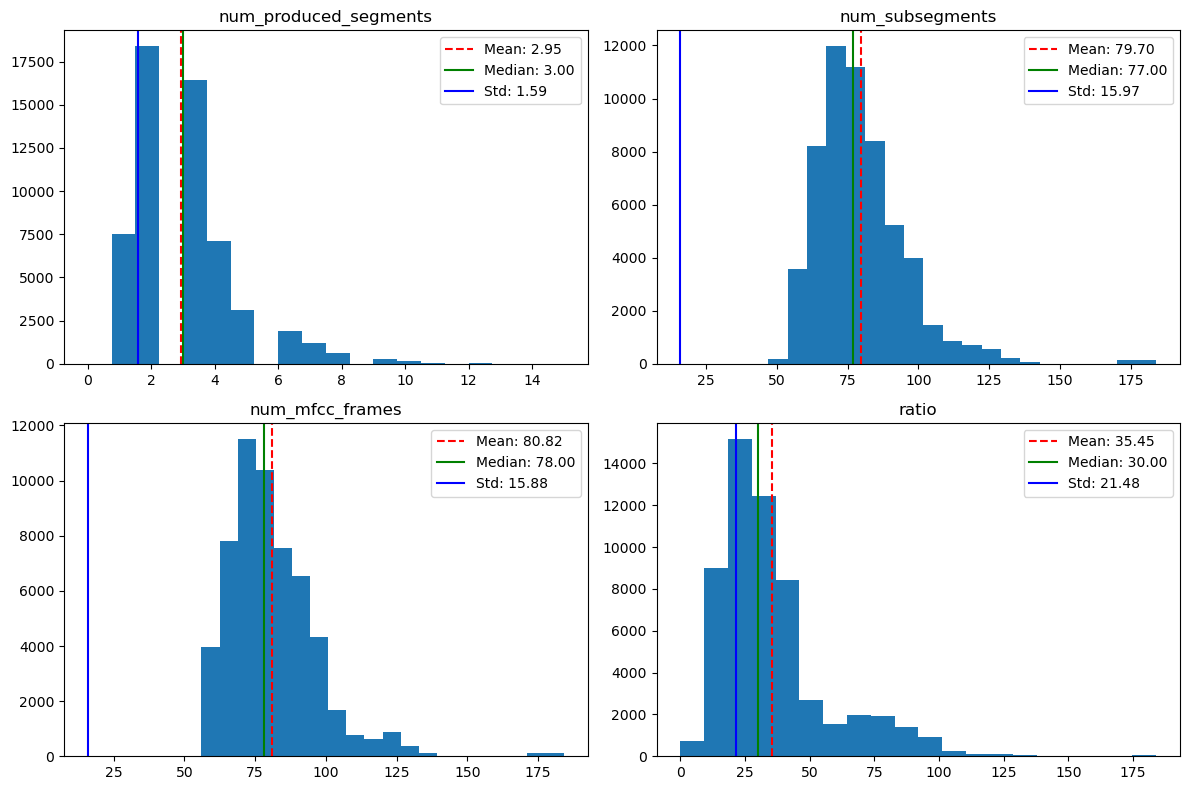

In [13]:
plot_subsegment_ratio_stat(stat_res)